In [1]:
!pip install transformers
!pip install sentencepiece

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import transformers
from transformers import AutoTokenizer, BertTokenizer, RobertaTokenizerFast, RobertaForTokenClassification
from transformers import  DistilBertForTokenClassification, RobertaTokenizer, RobertaModel
from transformers import XLNetTokenizer, XLNetForTokenClassification, XLNetModel, TFAutoModel
from torch.optim import AdamW

import torch
import torch.nn as nn
from torch.optim import SGD
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score

In [3]:
class DistilbertNER(nn.Module):
  """
  Implement NN class based on distilbert pretrained from Hugging face.
  Inputs : 
    tokens_dim : int specifyng the dimension of the classifier
  """
  
  def __init__(self, tokens_dim):
    super(DistilbertNER,self).__init__()
    
    if type(tokens_dim) != int:
            raise TypeError('Please tokens_dim should be an integer')

    if tokens_dim <= 0:
          raise ValueError('Classification layer dimension should be at least 1')

    self.pretrained = RobertaForTokenClassification.from_pretrained("roberta-base", num_labels = tokens_dim) #set the output of each token classifier = unique_lables


  def forward(self, input_ids, attention_mask, labels = None): #labels are needed in order to compute the loss
    """
  Forwad computation of the network
  Input:
    - inputs_ids : from model tokenizer
    - attention :  mask from model tokenizer
    - labels : if given the model is able to return the loss value
  """

    #inference time no labels
    if labels == None:
      out = self.pretrained(input_ids = input_ids, attention_mask = attention_mask )
      return out

    out = self.pretrained(input_ids = input_ids, attention_mask = attention_mask , labels = labels)
    return out

In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import transformers
from transformers import AutoTokenizer
from transformers import  DistilBertForTokenClassification
from transformers import XLNetTokenizer, XLNetModel, TFAutoModel
from torch.optim import AdamW

import torch
import torch.nn as nn
from torch.optim import SGD
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score

In [5]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import transformers
from transformers import AutoTokenizer
from transformers import  DistilBertForTokenClassification
from transformers import XLNetTokenizer, XLNetModel, TFAutoModel
from torch.optim import AdamW

import torch
import torch.nn as nn
from torch.optim import SGD
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.metrics import accuracy_score,f1_score, precision_score, recall_score

In [6]:
class NerDataset(torch.utils.data.Dataset):
  """
  Custom dataset implementation to get (text,labels) tuples
  Inputs:
   - df : dataframe with columns [tags, sentence]
  """
  
  def __init__(self, df):
    if not isinstance(df, pd.DataFrame):
      raise TypeError('Input should be a dataframe')
    
    if "tags" not in df.columns or "sentence" not in df.columns:
      raise ValueError("Dataframe should contain 'tags' and 'sentence' columns")

     
    
    tags_list = [i.split() for i in df["tags"].values.tolist()]
    texts = df["sentence"].values.tolist()

    self.texts = [tokenizer(text, padding = "max_length", truncation = True, return_tensors = "pt") for text in texts]
    self.labels = [match_tokens_labels(text, tags) for text,tags in zip(self.texts, tags_list)]

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    batch_text = self.texts[idx]
    batch_labels = self.labels[idx]

    return batch_text, torch.LongTensor(batch_labels)

In [7]:
class MetricsTracking():
  """
  In order make the train loop lighter I define this class to track all the metrics that we are going to measure for our model.
  """
  def __init__(self):

    self.total_acc = 0
    self.total_f1 = 0
    self.total_precision = 0
    self.total_recall = 0

  def update(self, predictions, labels , ignore_token = -100):
    '''
    Call this function every time you need to update your metrics.
    Where in the train there was a -100, were additional token that we dont want to label, so remove them.
    If we flatten the batch its easier to access the indexed = -100
    '''  
    predictions = predictions.flatten()
    labels = labels.flatten()
    
    predictions = predictions[labels != ignore_token]
    labels = labels[labels != ignore_token]

    predictions = predictions.to("cpu")
    labels = labels.to("cpu")

    acc = accuracy_score(labels,predictions)
    f1 = f1_score(labels, predictions, average = "macro")
    precision = precision_score(labels, predictions, average = "macro")
    recall = recall_score(labels, predictions, average = "macro")

    self.total_acc  += acc
    self.total_f1 += f1
    self.total_precision += precision
    self.total_recall  += recall

  def return_avg_metrics(self,data_loader_size):
    n = data_loader_size
    metrics = {
        "acc": round(self.total_acc / n ,3), 
        "f1": round(self.total_f1 / n, 3), 
        "precision" : round(self.total_precision / n, 3), 
        "recall": round(self.total_recall / n, 3)
          }
    return metrics   

In [8]:
def tags_2_labels(tags : str, tag2idx : dict):
  '''
  Method that takes a list of tags and a dictionary mapping and returns a list of labels (associated).
  Used to create the "label" column in df from the "tags" column.
  '''
  return [tag2idx[tag] if tag in tag2idx else unseen_label for tag in tags.split()] 

In [9]:
def tags_mapping(tags_series : pd.Series):
  """
  tag_series = df column with tags for each sentence.
  Returns:
    - dictionary mapping tags to indexes (label)
    - dictionary mappign inedexes to tags
    - The label corresponding to tag 'O'
    - A set of unique tags ecountered in the trainind df, this will define the classifier dimension
  """

  if not isinstance(tags_series, pd.Series):
      raise TypeError('Input should be a padas Series')

  unique_tags = set()
  
  for tag_list in df_train["tags"]:
    for tag in tag_list.split():
      unique_tags.add(tag)


  tag2idx = {k:v for v,k in enumerate(sorted(unique_tags))}
  idx2tag = {k:v for v,k in tag2idx.items()}

  unseen_label = tag2idx["O"]

  return tag2idx, idx2tag, unseen_label, unique_tags

In [10]:
def match_tokens_labels(tokenized_input, tags, ignore_token = -100):
        '''
        Used in the custom dataset.
        -100 will be tha label used to match additional tokens like [CLS] [PAD] that we dont care about. 
        Inputs : 
          - tokenized_input : tokenizer over the imput text -> {input_ids, attention_mask}
          - tags : is a single label array -> [O O O O O O O O O O O O O O B-tim O]
        
        Returns a list of labels that match the tokenized text -> [-100, 3,5,6,-100,...]
        '''

        #gives an array [ None , 0 , 1 ,2 ,... None]. Each index tells the word of reference of the token
        word_ids = tokenized_input.word_ids()

        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:

            if word_idx is None:
                label_ids.append(ignore_token)

            #if its equal to the previous word we can add the same label id of the provious or -100 
            else :
                try:
                  reference_tag = tags[word_idx]
                  label_ids.append(tag2idx[reference_tag])
                except:
                  label_ids.append(ignore_token)
              
            
            previous_word_idx = word_idx

        return label_ids

In [11]:
def freeze_model(model,num_layers = 1):
  """
  Freeze last num_layers of a model to prevent ctastrophic forgetting.
  Doesn't seem to work weel, its better to fine tune the entire netwok
  """
  for id , params in enumerate(model.parameters()):
    if id == len(list(model.parameters())) - num_layers: 
      print("last layer unfreezed")
      params.requires_grad = True
    else:
      params.requires_grad = False
  return model

In [12]:
def train_loop(model, train_dataset, dev_dataset, optimizer,  batch_size, epochs):

  train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
  dev_dataloader = DataLoader(dev_dataset, batch_size = batch_size, shuffle = True)

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model = model.to(device)

  train_metrics_list = {'loss':[], 'acc':[], 'precision':[], 'recall':[], 'f1':[] }
  test_metrics_list = {'loss':[], 'acc':[], 'precision':[], 'recall':[], 'f1':[] }



  for epoch in range(epochs): 
    
    train_metrics = MetricsTracking()
    total_loss_train = 0

    model.train() #train mode

    for train_data, train_label in tqdm(train_dataloader):

      train_label = train_label.to(device)
      '''
      squeeze in order to match the sizes. From [batch,1,seq_len] --> [batch,seq_len] 
      '''
      mask = train_data['attention_mask'].squeeze(1).to(device)
      input_id = train_data['input_ids'].squeeze(1).to(device)

      optimizer.zero_grad()
      
      output = model(input_id, mask, train_label)
      loss, logits = output.loss, output.logits
      predictions = logits.argmax(dim= -1) 

      #compute metrics
      train_metrics.update(predictions, train_label)
      total_loss_train += loss.item()

      #grad step
      loss.backward()
      optimizer.step()
    
    '''
    EVALUATION MODE
    '''            
    model.eval()

    dev_metrics = MetricsTracking()
    total_loss_dev = 0
    
    with torch.no_grad():
      for dev_data, dev_label in dev_dataloader:

        dev_label = dev_label.to(device)

        mask = dev_data['attention_mask'].squeeze(1).to(device)
        input_id = dev_data['input_ids'].squeeze(1).to(device)

        output = model(input_id, mask, dev_label)
        loss, logits = output.loss, output.logits

        predictions = logits.argmax(dim= -1)     

        dev_metrics.update(predictions, dev_label)
        total_loss_dev += loss.item()
    
    train_results = train_metrics.return_avg_metrics(len(train_dataloader))
    dev_results = dev_metrics.return_avg_metrics(len(dev_dataloader))

    train_metrics_list['loss'].append(total_loss_train / len(train_dataset))
    train_metrics_list['acc'].append(train_results['acc'])
    train_metrics_list['precision'].append(train_results['precision'])
    train_metrics_list['recall'].append(train_results['recall'])
    train_metrics_list['f1'].append(train_results['f1'])

    test_metrics_list['loss'].append(total_loss_dev / len(dev_dataset))
    test_metrics_list['acc'].append(dev_results['acc'])
    test_metrics_list['precision'].append(dev_results['precision'])
    test_metrics_list['recall'].append(dev_results['recall'])
    test_metrics_list['f1'].append(dev_results['f1'])

    print(f"TRAIN \nLoss: {total_loss_train / len(train_dataset)} \nMetrics {train_results}\n" ) 
    print(f"VALIDATION \nLoss {total_loss_dev / len(dev_dataset)} \nMetrics{dev_results}\n" )
  return train_metrics_list, test_metrics_list

In [13]:
df_train=pd.read_csv('final_train.csv', encoding='utf-8', encoding_errors='ignore')
df_train.columns=['sentence','tags']

df_test=pd.read_csv('final_test.csv', encoding='utf-8', encoding_errors='ignore')
df_test.columns=['sentence','tags']

df_dev=df_test

In [14]:
train_texts = df_train.sentence.values.tolist()
train_labels= df_train.tags.values.tolist()

test_texts = df_test.sentence.values.tolist()
test_labels= df_test.tags.values.tolist()

In [15]:

#create tag-label mapping
tag2idx, idx2tag , unseen_label, unique_tags = tags_mapping(df_train["tags"])

#create the label column from tag. Unseen labels will be tagged as "O"
for df in [df_train, df_dev, df_test]:
  df["labels"] = df["tags"].apply(lambda tags : tags_2_labels(tags, tag2idx))

In [16]:
#original text
text = df_train["sentence"].values.tolist()

#toeknized text
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
text_tokenized = tokenizer(text , padding ='max_length', truncation = True, return_tensors = "pt" )

#mapping token to original word
word_ids = text_tokenized.word_ids()

In [17]:
model = DistilbertNER(len(unique_tags))
#Prevent Catastrofic Forgetting
#model = freeze_model(model, num_layers = 2)

#datasets
train_dataset = NerDataset(df_train)
dev_dataset = NerDataset(df_dev)

lr = 1e-2
optimizer = SGD(model.parameters(), lr=lr, momentum = 0.9)  


#MAIN
parameters = {
    "model": model,
    "train_dataset": train_dataset,
    "dev_dataset" : dev_dataset,
    "optimizer" : optimizer,
    "batch_size" : 48,
    "epochs" : 8
}

train_metrics_list, test_metrics_list = train_loop(**parameters)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able

TRAIN 
Loss: 0.011387199384328403 
Metrics {'acc': 0.828, 'f1': 0.641, 'precision': 0.68, 'recall': 0.637}

VALIDATION 
Loss 0.006288656979376832 
Metrics{'acc': 0.917, 'f1': 0.789, 'precision': 0.807, 'recall': 0.789}



100%|██████████| 138/138 [03:08<00:00,  1.37s/it]


TRAIN 
Loss: 0.005620743172681921 
Metrics {'acc': 0.92, 'f1': 0.804, 'precision': 0.827, 'recall': 0.799}

VALIDATION 
Loss 0.004882550847328685 
Metrics{'acc': 0.929, 'f1': 0.858, 'precision': 0.871, 'recall': 0.857}



100%|██████████| 138/138 [03:08<00:00,  1.37s/it]


TRAIN 
Loss: 0.004360582589913814 
Metrics {'acc': 0.938, 'f1': 0.864, 'precision': 0.879, 'recall': 0.861}

VALIDATION 
Loss 0.004356596317392645 
Metrics{'acc': 0.942, 'f1': 0.876, 'precision': 0.889, 'recall': 0.878}



100%|██████████| 138/138 [03:08<00:00,  1.37s/it]


TRAIN 
Loss: 0.003994064648146709 
Metrics {'acc': 0.942, 'f1': 0.883, 'precision': 0.899, 'recall': 0.881}

VALIDATION 
Loss 0.004161682898016024 
Metrics{'acc': 0.94, 'f1': 0.874, 'precision': 0.87, 'recall': 0.89}



100%|██████████| 138/138 [03:08<00:00,  1.37s/it]


TRAIN 
Loss: 0.003609722206035733 
Metrics {'acc': 0.948, 'f1': 0.9, 'precision': 0.91, 'recall': 0.899}

VALIDATION 
Loss 0.0041673602165835716 
Metrics{'acc': 0.945, 'f1': 0.93, 'precision': 0.94, 'recall': 0.932}



100%|██████████| 138/138 [03:08<00:00,  1.37s/it]


TRAIN 
Loss: 0.0032133382693386135 
Metrics {'acc': 0.954, 'f1': 0.919, 'precision': 0.927, 'recall': 0.919}

VALIDATION 
Loss 0.0036287844508109597 
Metrics{'acc': 0.952, 'f1': 0.934, 'precision': 0.939, 'recall': 0.937}



100%|██████████| 138/138 [03:08<00:00,  1.37s/it]


TRAIN 
Loss: 0.0027730722640190377 
Metrics {'acc': 0.959, 'f1': 0.938, 'precision': 0.946, 'recall': 0.937}

VALIDATION 
Loss 0.003911599901832289 
Metrics{'acc': 0.948, 'f1': 0.928, 'precision': 0.935, 'recall': 0.932}



100%|██████████| 138/138 [03:08<00:00,  1.37s/it]


TRAIN 
Loss: 0.0026723422710770396 
Metrics {'acc': 0.96, 'f1': 0.943, 'precision': 0.955, 'recall': 0.94}

VALIDATION 
Loss 0.003472438602481305 
Metrics{'acc': 0.952, 'f1': 0.935, 'precision': 0.941, 'recall': 0.937}



In [18]:
train_metrics_list

{'loss': [0.011387199384328403,
  0.005620743172681921,
  0.004360582589913814,
  0.003994064648146709,
  0.003609722206035733,
  0.0032133382693386135,
  0.0027730722640190377,
  0.0026723422710770396],
 'acc': [0.828, 0.92, 0.938, 0.942, 0.948, 0.954, 0.959, 0.96],
 'precision': [0.68, 0.827, 0.879, 0.899, 0.91, 0.927, 0.946, 0.955],
 'recall': [0.637, 0.799, 0.861, 0.881, 0.899, 0.919, 0.937, 0.94],
 'f1': [0.641, 0.804, 0.864, 0.883, 0.9, 0.919, 0.938, 0.943]}

In [19]:
# import matplotlib.pyplot as plt

# # Define the x-axis as the number of epochs
# epochs = range(1, len(train_metrics_list['loss']) + 1)

# # Plot the training and test loss per epoch
# plt.plot(epochs, train_metrics_list['loss'], label='Train Loss')
# plt.plot(epochs, test_metrics_list['loss'], label='Test Loss')
# plt.title('Training and Test Loss per Epoch')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# # Plot the training and test accuracy per epoch
# plt.plot(epochs, train_metrics_list['acc'], label='Train Accuracy')
# plt.plot(epochs, test_metrics_list['acc'], label='Test Accuracy')
# plt.title('Training and Test Accuracy per Epoch')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# # Plot the training and test F1 score per epoch
# plt.plot(epochs, train_metrics_list['f1'], label='Train F1 Score')
# plt.plot(epochs, test_metrics_list['f1'], label='Test F1 Score')
# plt.title('Training and Test F1 Score per Epoch')
# plt.xlabel('Epoch')
# plt.ylabel('F1 Score')
# plt.legend()
# plt.show()

# # Plot the training and test precision per epoch
# plt.plot(epochs, train_metrics_list['precision'], label='Train Precision')
# plt.plot(epochs, test_metrics_list['precision'], label='Test Precision')
# plt.title('Training and Test Precision per Epoch')
# plt.xlabel('Epoch')
# plt.ylabel('Precision')
# plt.legend()
# plt.show()

# # Plot the training and test recall per epoch
# plt.plot(epochs, train_metrics_list['recall'], label='Train Recall')
# plt.plot(epochs, test_metrics_list['recall'], label='Test Recall')
# plt.title('Training and Test Recall per Epoch')
# plt.xlabel('Epoch')
# plt.ylabel('Recall')
# plt.legend()
# plt.show()

In [22]:
def draw_plots(y1, y2, x_name, y_name, title, legend_1,legend_2, x):

    import matplotlib.pyplot as plt
    import matplotlib.font_manager as fm

    # Define the font properties
    font_path = './Arial.ttf'  
    font_prop = fm.FontProperties(fname=font_path)

   

    f = plt.figure(figsize = (10,6))
    
    # naming the x axis
    plt.xlabel(x_name, fontsize=12, fontproperties=font_prop)
    # naming the y axis
    plt.ylabel(y_name,fontsize=12, fontproperties=font_prop)

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    #create plot
    plt.plot(range(len(y1)), y1, "o-",  label = legend_1)
    plt.plot(range(len(y2)), y2, "o-",  label = legend_2)
    plt.legend()
    plt.title(title)
    plt.show()

    f.savefig("./Roberta_D1/Plot{}.svg".format(x), format='svg', dpi=300)
    f.savefig("./Roberta_D1/Plot{}.tiff".format(x), format='tiff', dpi=300)
    f.savefig("./Roberta_D1/Plot{}.jpeg".format(x), format='jpeg', dpi=300)
    f.savefig("./Roberta_D1/Plot{}.pdf".format(x), format='pdf', dpi=300)

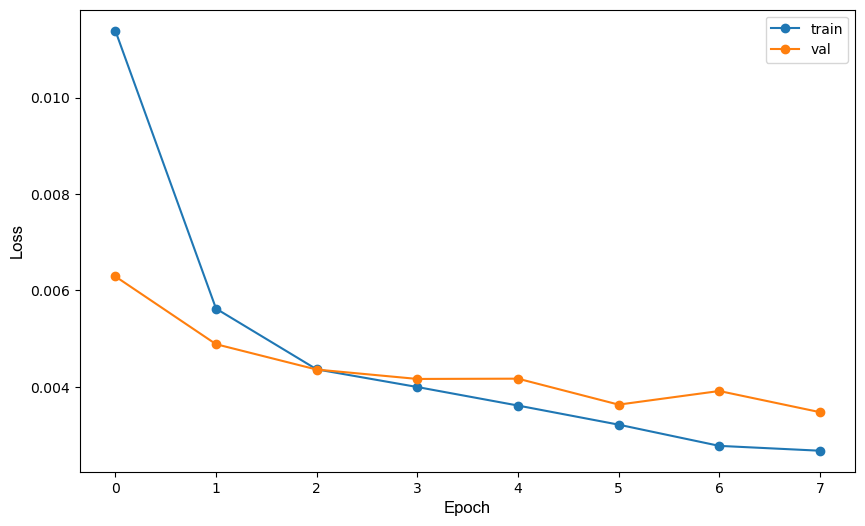

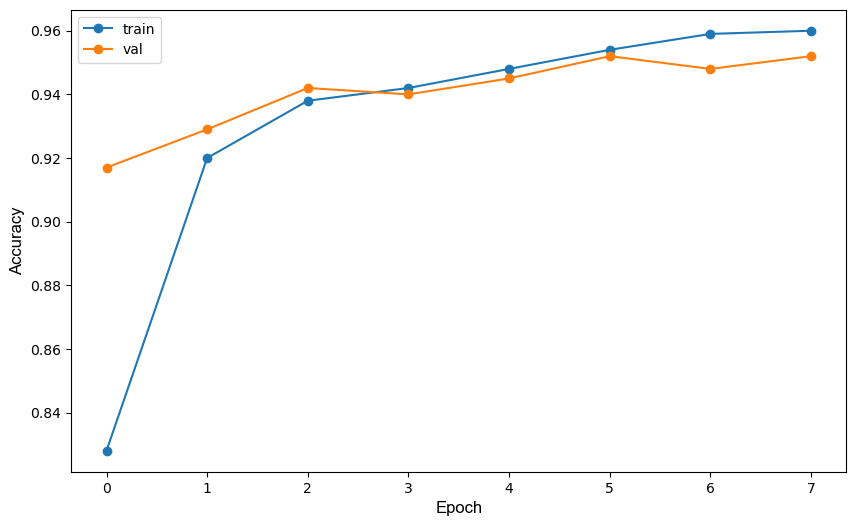

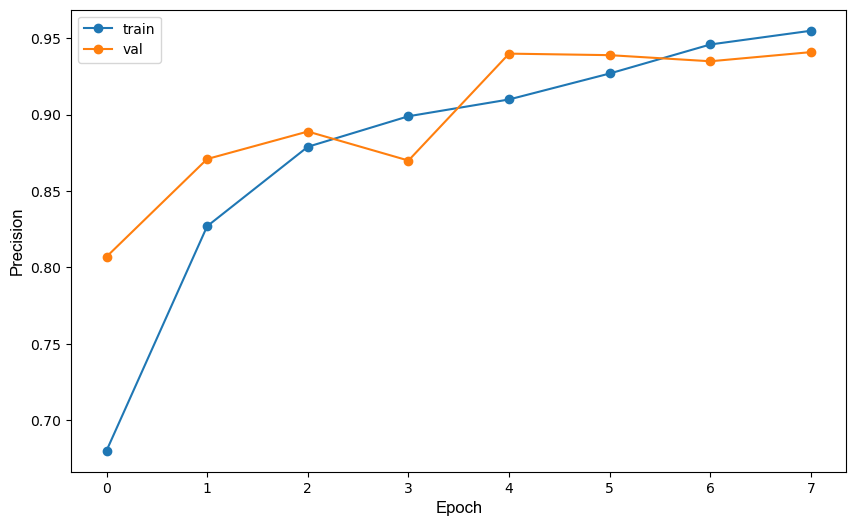

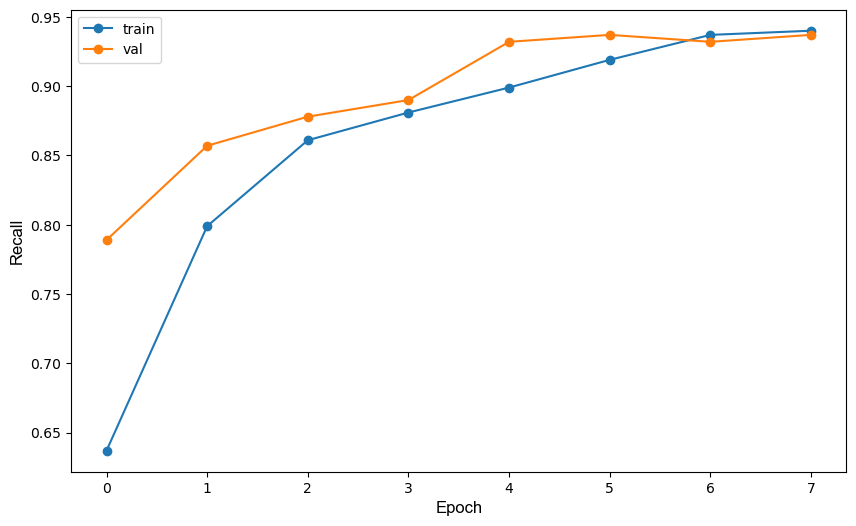

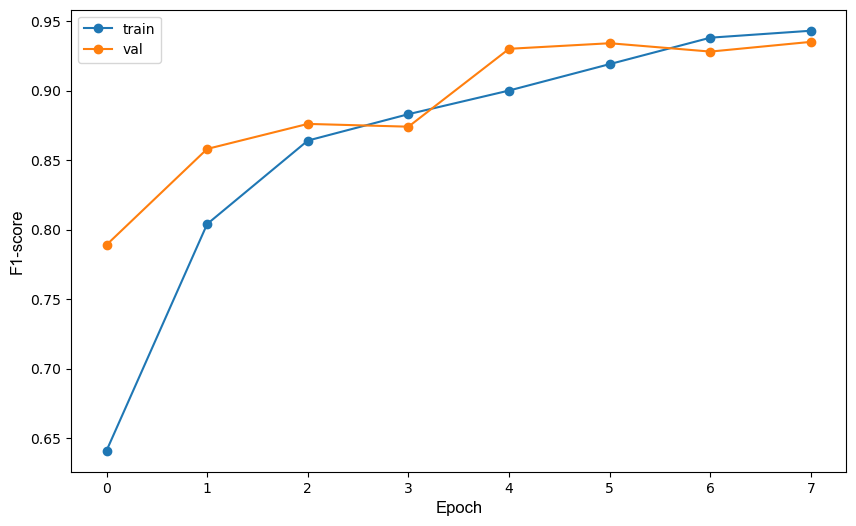

In [23]:
draw_plots(train_metrics_list['loss'], test_metrics_list['loss'], 'Epoch', 'Loss', '', 'train','val', 10)
draw_plots(train_metrics_list['acc'], test_metrics_list['acc'], 'Epoch', 'Accuracy', '', 'train','val', 20)
draw_plots(train_metrics_list['precision'], test_metrics_list['precision'], 'Epoch', 'Precision', '', 'train','val', 30)
draw_plots(train_metrics_list['recall'], test_metrics_list['recall'], 'Epoch', 'Recall', '', 'train','val', 40)
draw_plots(train_metrics_list['f1'], test_metrics_list['f1'], 'Epoch', 'F1-score', '', 'train','val', 50)